# Setup

In [1]:
## !pip install numpy scipy

In [1]:
import collections
import functools as ft
import itertools as it
import multiprocessing as mp
import numpy as np
import pandas as pd
import scipy.optimize as so
import scipy.stats as st

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt

In [3]:
F = st.uniform(0, 1)

# Implementation

In [4]:
def revenue(values, virtual_values):
    return max(np.array(values).max(), np.array(virtual_values).max())

def trial(y, cost, seed, num_players, F):
    np.random.seed(seed)
    values = np.random.uniform(0, 1, size=num_players)
    virtual_values = values - (1 - F.cdf(values) / F.pdf(values))
    ret = dict()
    ## Important: this points to the first *unselected* agent
    for n in range(num_players - 1):
        ret[n] = revenue(max(values[n], y), virtual_values[n + 1:]) - cost - revenue([y], virtual_values[n:])
    ret[num_players - 1] = revenue([max(values[-1], y)], [-np.inf]) - cost - revenue([y], virtual_values[-1:])
    return y, cost, seed, values, ret

In [5]:
def run_auction(ys, costs, num_players, F, num_trials=10_000, seed=0):
    values = F.rvs(size=(num_trials, num_players))
    virtual_values = values - (1 - F.cdf(values) / F.pdf(values))
    ys = ys.reshape(1, -1)
    costs = costs.reshape(1, 1, -1)
    gittins_index = dict()
    reservation_values = np.zeros((num_trials, costs.shape[1]))
    halt = np.zeros((num_trials, costs.shape[-1]), dtype=bool)
    for j in range(num_players):
        # trials x ys x costs
        expected_improvement = (np.fmax(ys, np.fmax(values[:,j], virtual_values[:,j + 1:].max(axis=1, initial=0)).reshape(-1, 1))
                                - np.fmax(ys, virtual_values[:,j:].max(axis=1, initial=0).reshape(-1, 1))).reshape(num_trials, ys.shape[1], 1) - costs
        signs = np.sign(expected_improvement.mean(axis=0))
        hits = np.where(np.diff(signs, axis=0))
        gittins_index[j] = pd.Series(dict(zip(costs.ravel()[hits[1]], ys.ravel()[hits[0]])), index=costs.ravel()).fillna(np.inf * pd.Series(signs[0], index=costs.ravel()))
        halt |= reservation_values > gittins_index[j].values.reshape(1, -1)
        reservation_values = np.where(halt, 
                                      np.fmax(reservation_values, virtual_values.max(axis=1).reshape(-1, 1)), 
                                      np.fmax(reservation_values, values[:,j].reshape(-1, 1)))
    gittins_index = pd.DataFrame(gittins_index)
    gittins_index.index.name = 'cost'
    gittins_index.columns.name = 'num_inspected'
    revenue = pd.Series(reservation_values.mean(axis=0), index=costs.ravel())
    return gittins_index, revenue

In [8]:
gittins_index, revenue = run_auction(np.linspace(0, 1, 1000), np.logspace(-3, -1, 20), 5, F)

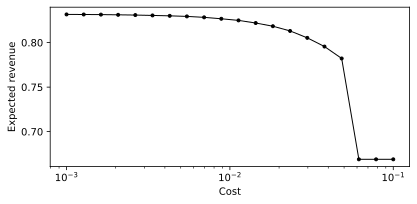

In [11]:
plt.clf()
plt.gcf().set_size_inches(6, 3)
plt.plot(revenue.index, revenue, lw=1, c='k', marker='.')
plt.xlabel('Cost')
plt.ylabel('Expected revenue')
plt.xscale('log')
plt.tight_layout()

# Results

In [23]:
with mp.Pool() as pool:
    temp = pool.starmap(ft.partial(trial, num_players=5, F=F), 
                        it.product(np.linspace(0, 1, 100), [1e-2], range(50_000)))
result = collections.defaultdict(lambda: collections.defaultdict(dict))
for y, c, t, v, f in temp:
    for k in f:
        result[(k, c)][t][y] = f[k]

In [24]:
index = collections.defaultdict(dict)
index_sd = collections.defaultdict(dict)
for k, c in result:
    mean = pd.DataFrame(result[(k, c)]).mean(axis=1)
    std = pd.DataFrame(result[(k, c)]).std(axis=1)
    hit = np.where(np.diff(np.sign(mean)))[0]
    if hit.any():
        index[c][k] = mean.index[hit].item()
        index_sd[c][k] = std.iloc[hit]
    elif mean[0] < 0:
        index[c][k] = -np.inf
        index_sd[c][k] = 0
    else:
        index[c][k] = np.inf
        index_sd[c][k] = 0

In [25]:
gittins_index_table = pd.DataFrame(index)
gittins_index_table.index.name = 'num_inspected'
gittins_index_table.columns.name = 'cost'
gittins_index_table

cost,0.01
num_inspected,
0,0.757576
1,0.767677
2,0.777778
3,0.787879
4,0.797980
